## Project Title: Income Level Prediction Using Economic Census Data: A Data Science Exploration




In [30]:
#Import useful libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix



In [2]:
census_data = pd.read_csv( "census.csv")

#Check data 
census_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
dims = census_data.shape
print('The data contains {} rows and {} columns.'.format(dims[0], dims[1]))

The data contains 48842 rows and 15 columns.


In [4]:
#Clean data 
census_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


# Data Cleaning and Preparation

In [5]:
#Count number of "?" in dataset
count_question_marks = (census_data == "?").sum().sum()
print(f"The current number of ? is: {count_question_marks}")

The current number of ? is: 6465


In [6]:
#Replaces all occurrences of the "?" character in the income_data dataset with NaN (Not a Number) values
#Handle missing or unknown data in a dataset.
census_data=census_data.replace(to_replace="?",value=np.nan)

In [7]:
#Check whether "?" characters have been replaced correctly 
print(census_data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [8]:
#Count number of "?" in dataset
count_question_marks = (census_data == "?").sum().sum()
print(f"The current number of ? is: {count_question_marks}")

The current number of ? is: 0


# Exploratory Data Analysis

### Descriptive Statistics both Continuous and Categorical variables 

In [9]:
# Continuous variables
continuous_vars = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Compute statistics for continuous variables
stats = census_data[continuous_vars].describe()

# Add range to the stats
stats.loc['range'] = stats.loc['max'] - stats.loc['min']

# Print statistics for continuous variables
print(stats.loc[['mean', '50%', 'std', 'range']])


             age        fnlwgt  education-num  capital-gain  capital-loss  \
mean   38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
50%    37.000000  1.781445e+05      10.000000      0.000000      0.000000   
std    13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
range  73.000000  1.478115e+06      15.000000  99999.000000   4356.000000   

       hours-per-week  
mean        40.422382  
50%         40.000000  
std         12.391444  
range       98.000000  


In [10]:
"""
The age within the dataset ranges from 17 to 90 years old. 

Mean is slightly higher than the median (50th percentile) in a dataset. Suggests that the distribution of 
ages is right-skewed or positively skewed. The following is possible:

Right-Skewed Distribution: Indicate that there are relatively more older individuals in the dataset that 
                           are pulling the mean upwards, but not enough to shift the median significantly.

Presence of Outliers: There might be a few very high age values (outliers) that are moving up the overall average 
                      (mean) of the dataset, as these outliers have more effect on the mean than on the median.

Interpretation: A majority of the individuals in the dataset are younger (below the mean age of 38.64 years), 
                but a significant number of older individuals are pushing the average age up.

"""

'\nThe age within the dataset ranges from 17 to 90 years old. \n\nMean is slightly higher than the median (50th percentile) in a dataset. Suggests that the distribution of \nages is right-skewed or positively skewed. The following is possible:\n\nRight-Skewed Distribution: Indicate that there are relatively more older individuals in the dataset that \n                           are pulling the mean upwards, but not enough to shift the median significantly.\n\nPresence of Outliers: There might be a few very high age values (outliers) that are moving up the overall average \n                      (mean) of the dataset, as these outliers have more effect on the mean than on the median.\n\nInterpretation: A majority of the individuals in the dataset are younger (below the mean age of 38.64 years), \n                but a significant number of older individuals are pushing the average age up.\n\n'

In [11]:
# Categorical variables
categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

# Compute frequency distribution for categorical variables
for var in categorical_vars:
    print("\nFrequency distribution for:", var)
    print(census_data[var].value_counts())


Frequency distribution for: workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

Frequency distribution for: education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64

Frequency distribution for: marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital-status, dtype: int64

Frequ

### Brief Data Visualisation

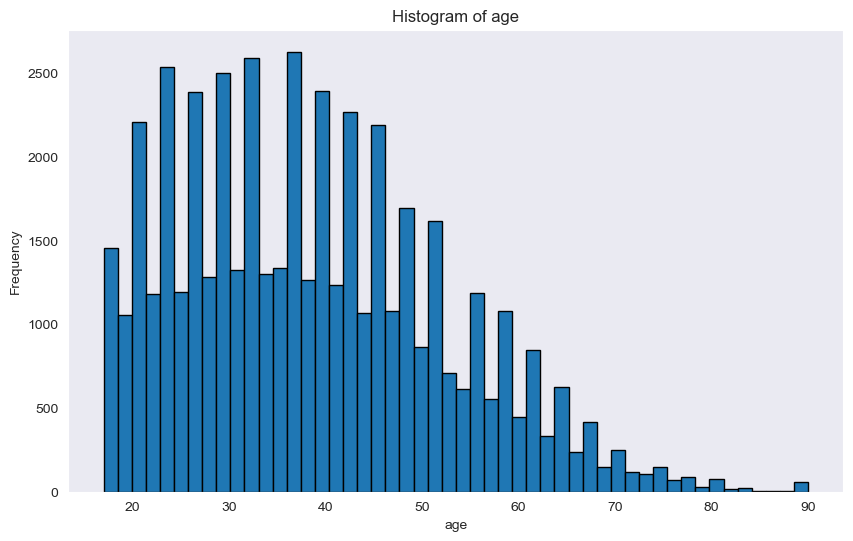

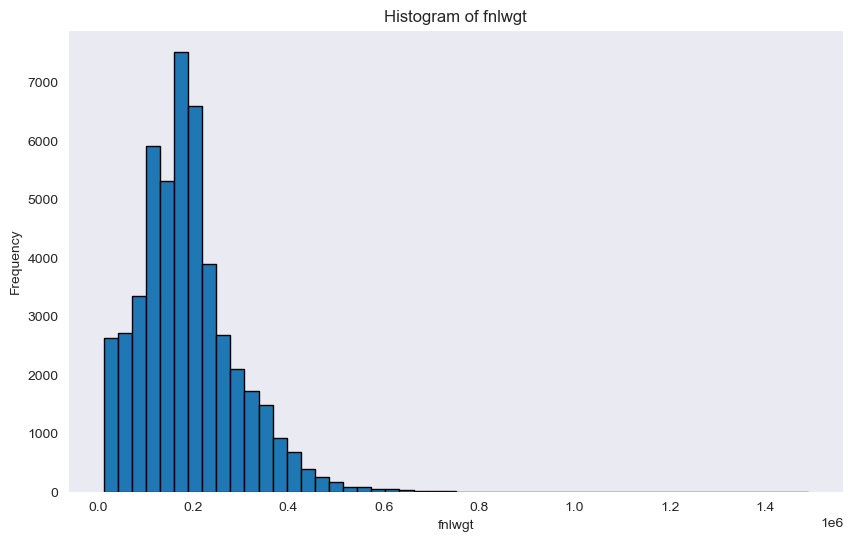

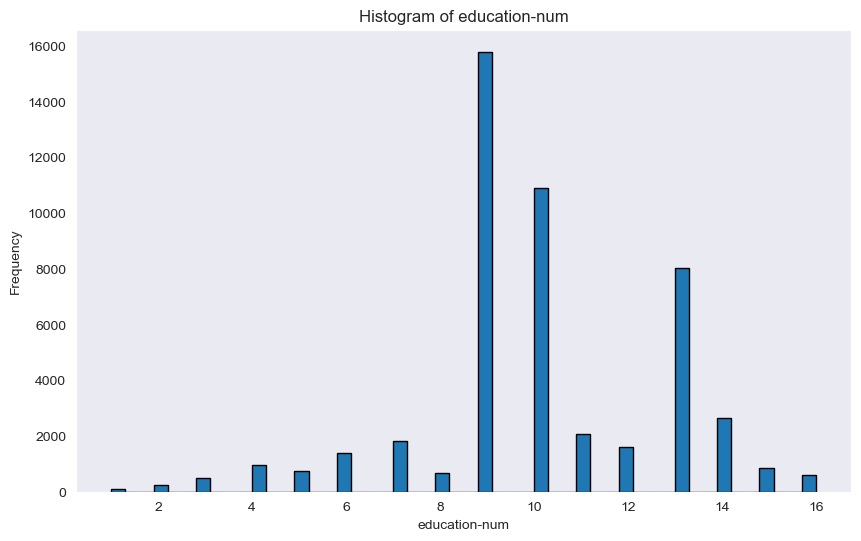

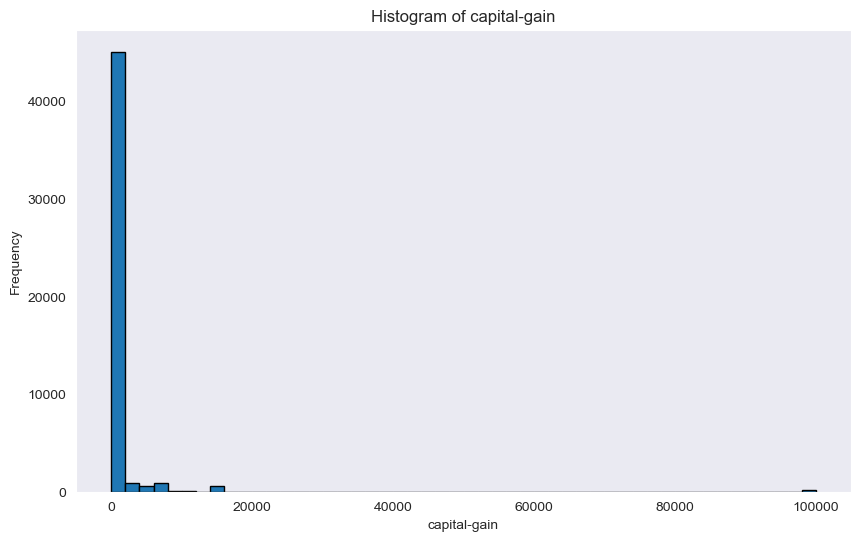

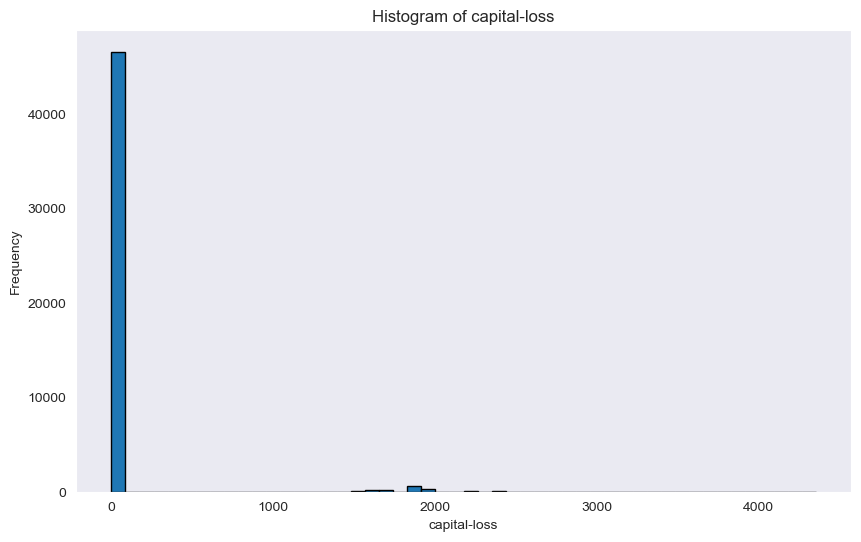

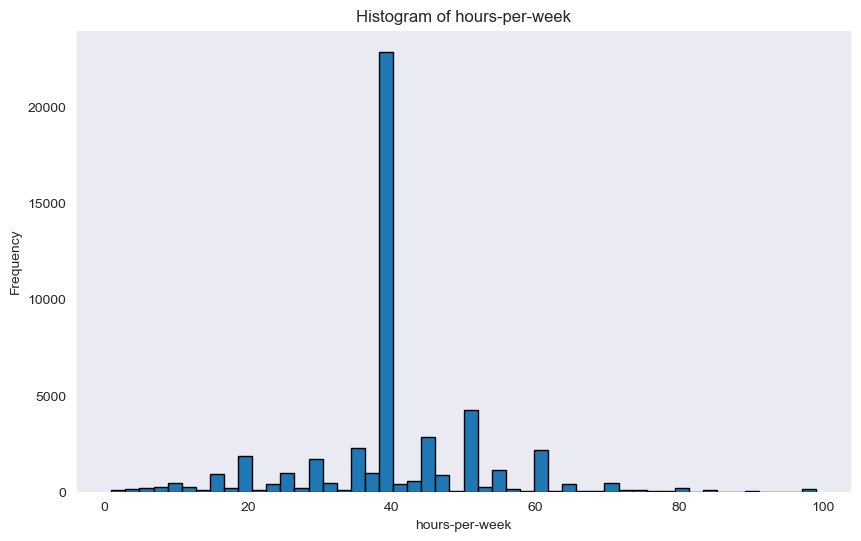

In [12]:
#Histograms for continuous variables 
#'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'
for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    census_data[var].hist(bins=50, edgecolor='black')
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()

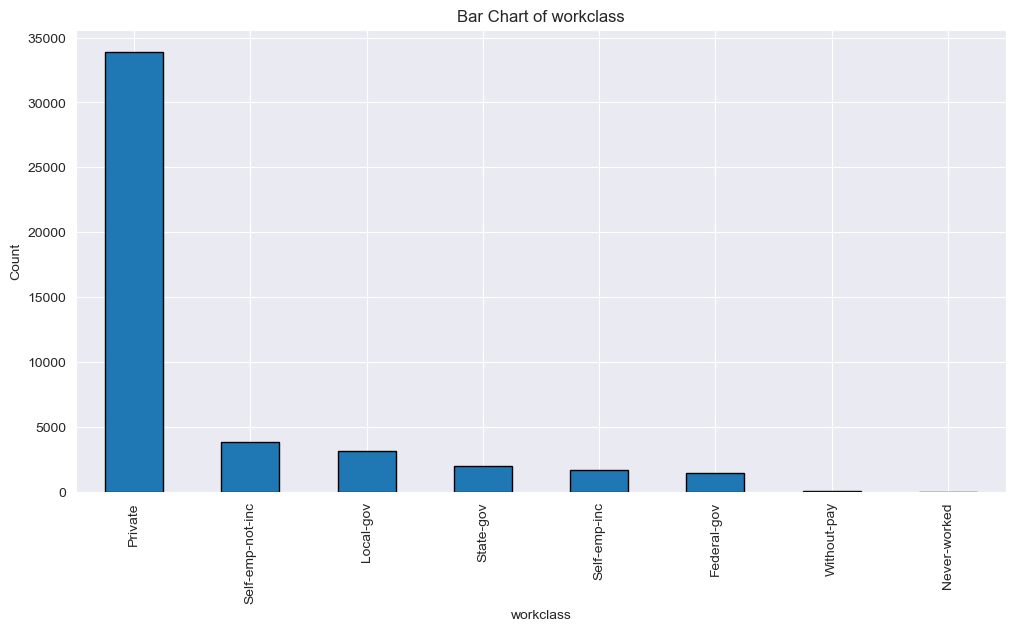

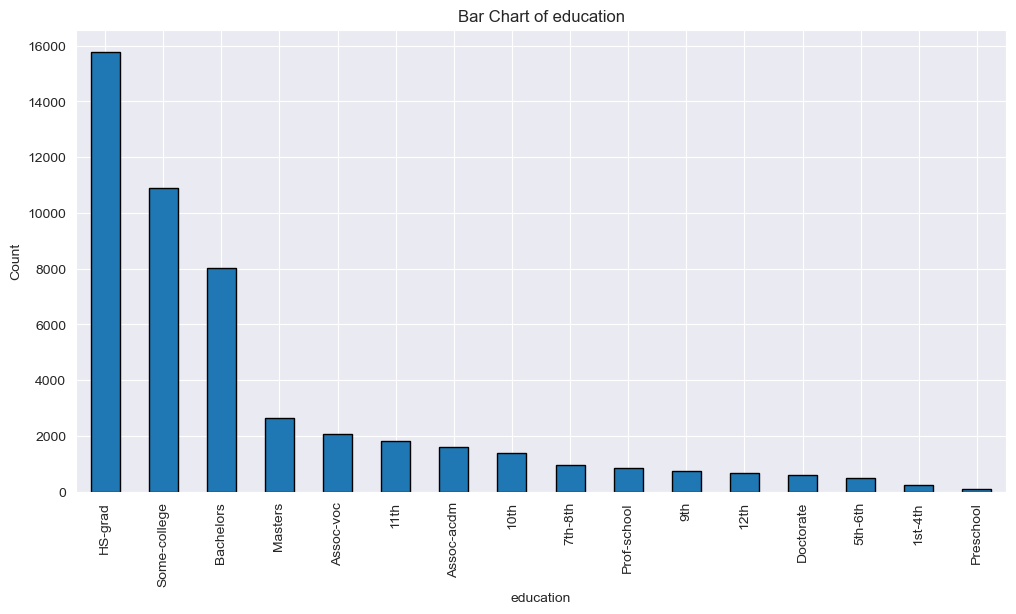

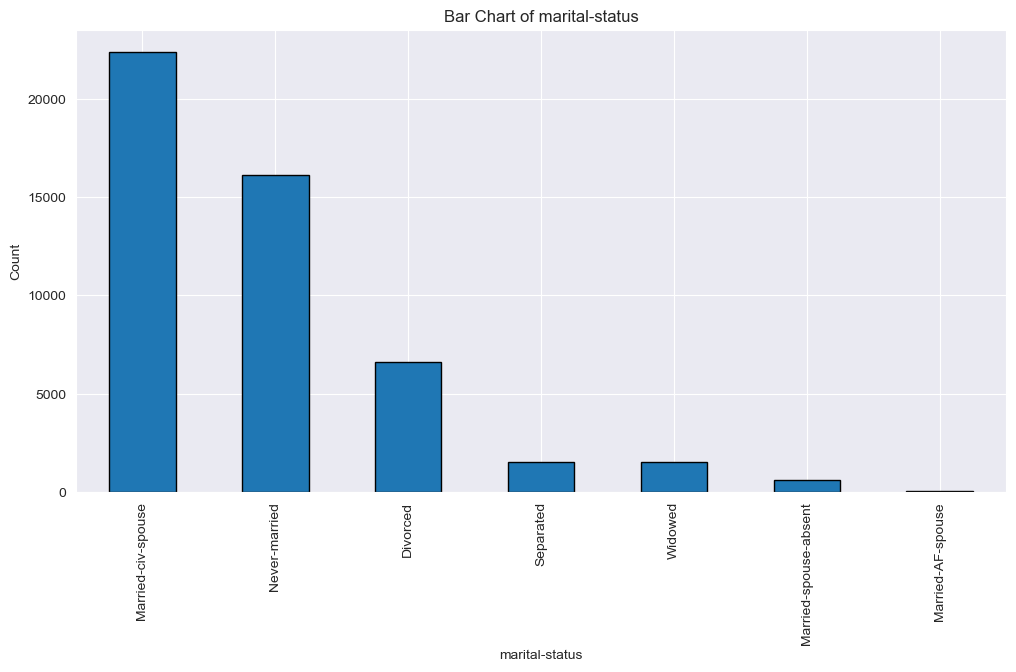

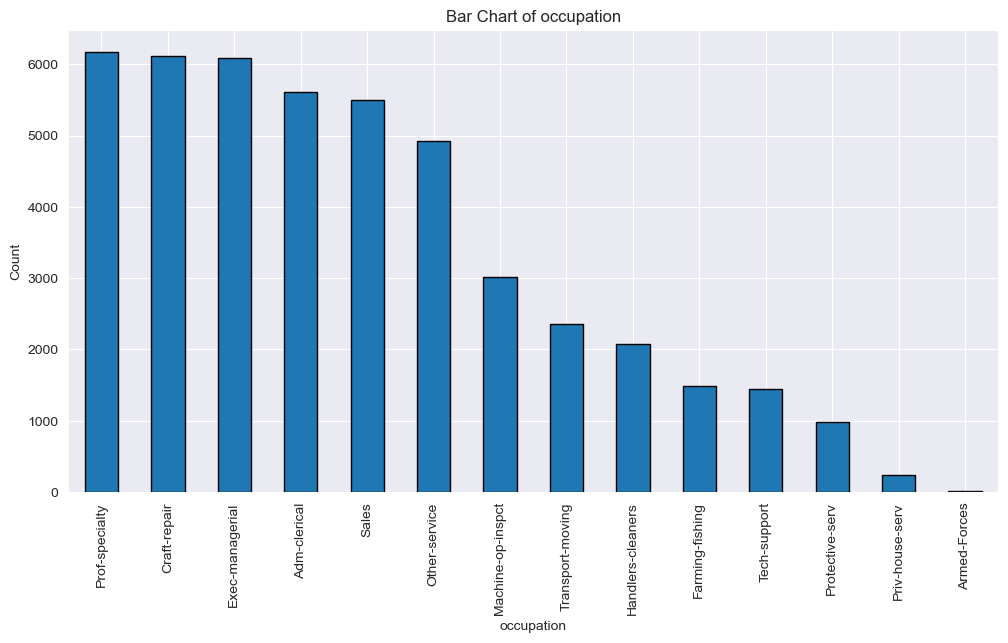

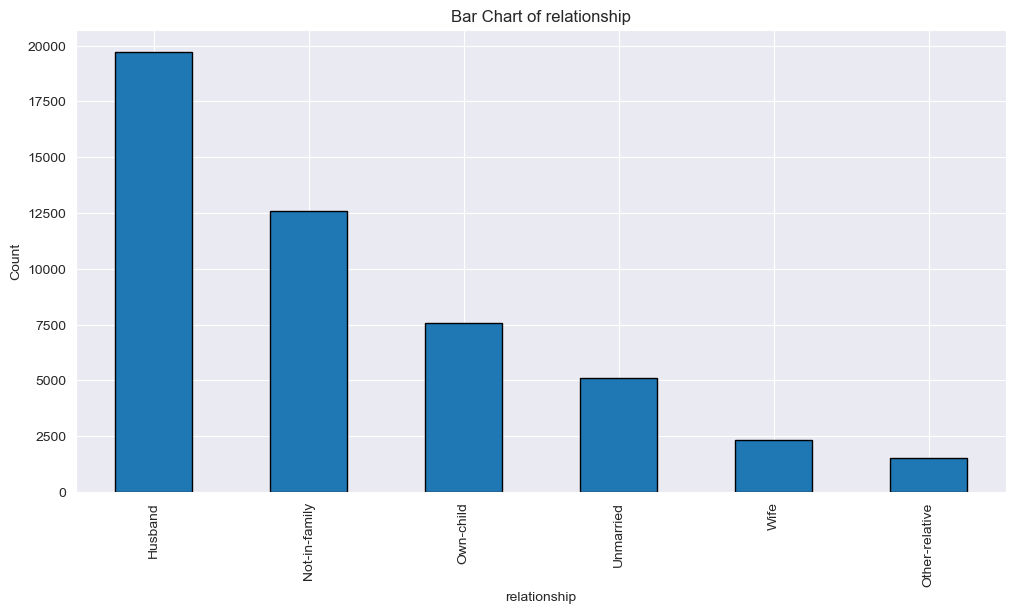

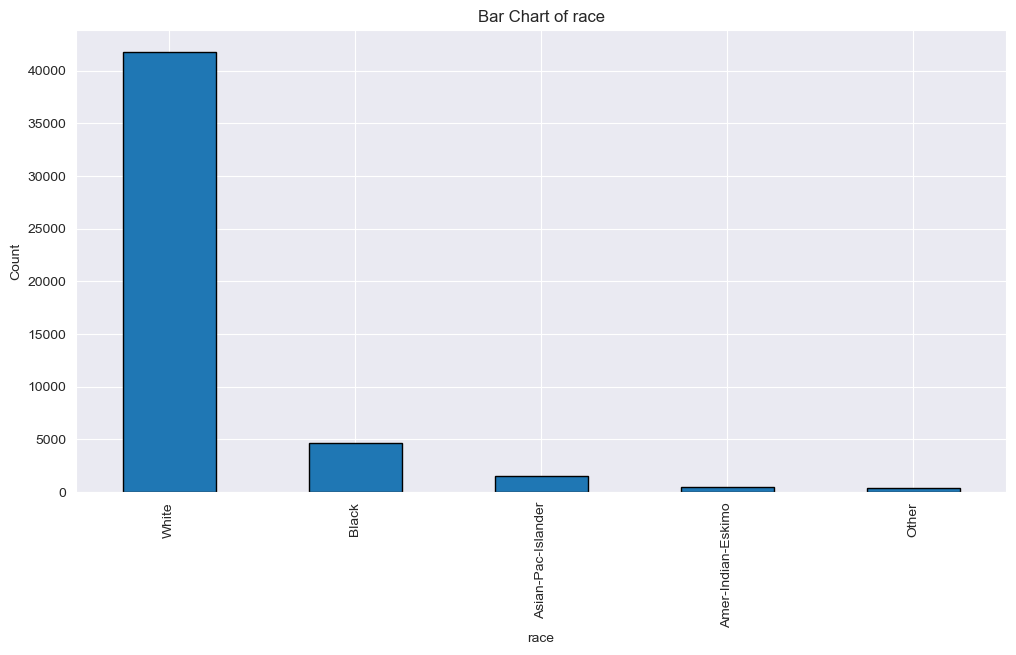

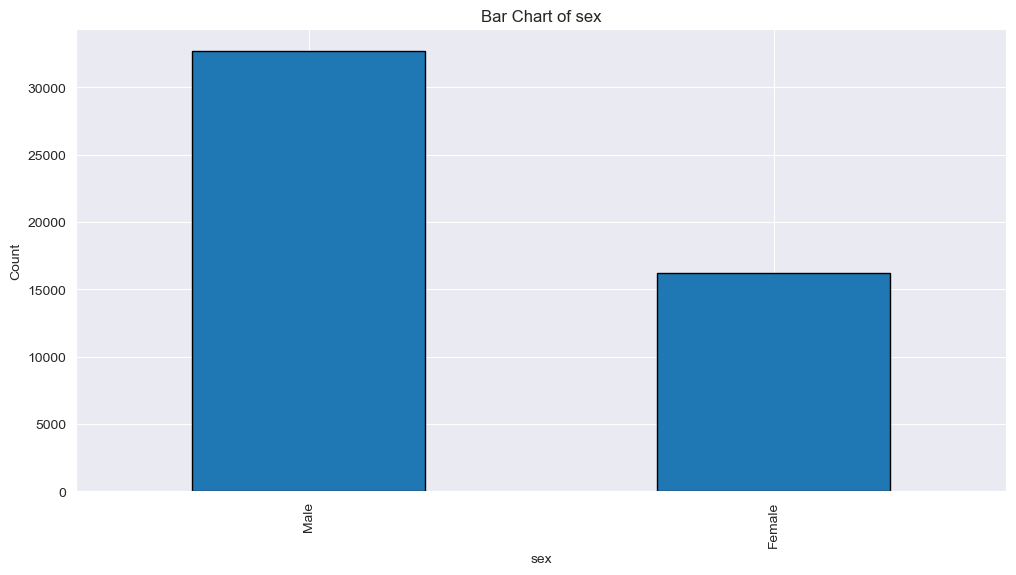

In [13]:
#Bar charts for categorical variables 
#'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'
categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
for var in categorical_vars:
    plt.figure(figsize=(12, 6))
    census_data[var].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(f'Bar Chart of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.show()


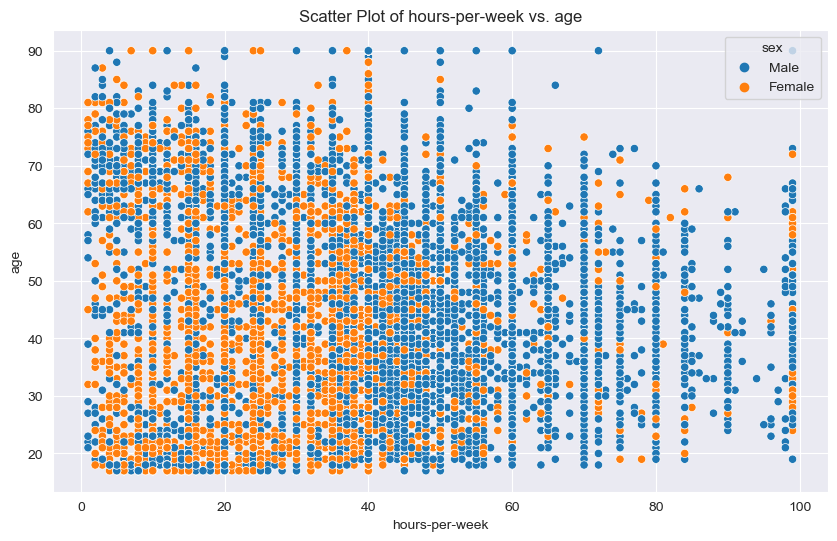

In [14]:
# Do older individuals tend to work fewer hours?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=census_data, x='hours-per-week', y='age', hue='sex')  # Using 'sex' as hue for demonstration
plt.title('Scatter Plot of hours-per-week vs. age')
plt.grid(True)
plt.show()

# Feature Engineering

In [15]:
# Creating a new feature for age groups
census_data['age_group'] = pd.cut(census_data['age'], 
                                  bins=[0, 25, 45, 65, 100], 
                                  labels=['Young', 'Adult', 'Middle-aged', 'Senior'])

# Creating a new feature that combines education and occupation
census_data['edu_occ'] = census_data['education'] + "_" + census_data['occupation']

# Creating binary features for capital gain/loss
census_data['has_capital_gain'] = census_data['capital-gain'] > 0
census_data['has_capital_loss'] = census_data['capital-loss'] > 0

# Creating a feature for total capital change
census_data['total_capital'] = census_data['capital-gain'] - census_data['capital-loss']

# Creating a feature for hours per week categories
census_data['hours_per_week_cat'] = pd.cut(census_data['hours-per-week'], 
                                           bins=[0, 20, 40, 60, 80, 100], 
                                           labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])


In [16]:
# Displaying the first few rows of the dataset with the new features
census_data.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,capital-loss,hours-per-week,native-country,income,age_group,edu_occ,has_capital_gain,has_capital_loss,total_capital,hours_per_week_cat
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,...,0,40,United-States,<=50K,Young,11th_Machine-op-inspct,False,False,0,Low
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,0,50,United-States,<=50K,Adult,HS-grad_Farming-fishing,False,False,0,Medium
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,...,0,40,United-States,>50K,Adult,Assoc-acdm_Protective-serv,False,False,0,Low
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,0,40,United-States,>50K,Adult,Some-college_Machine-op-inspct,True,False,7688,Low
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,...,0,30,United-States,<=50K,Young,NaN,False,False,0,Low


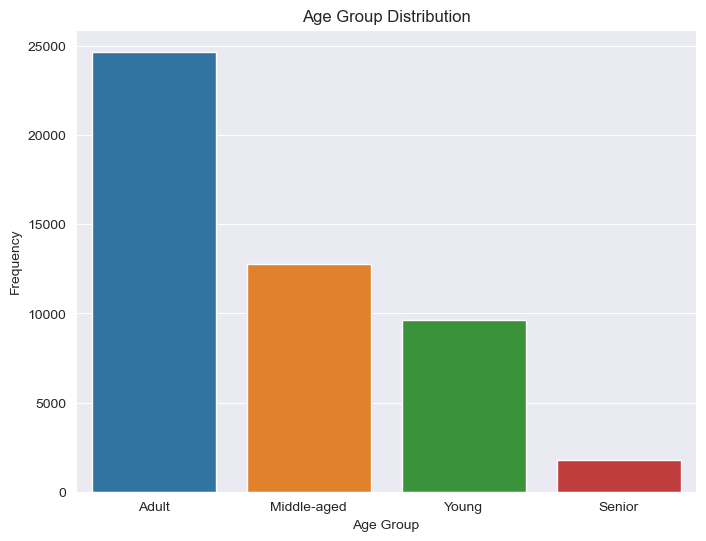

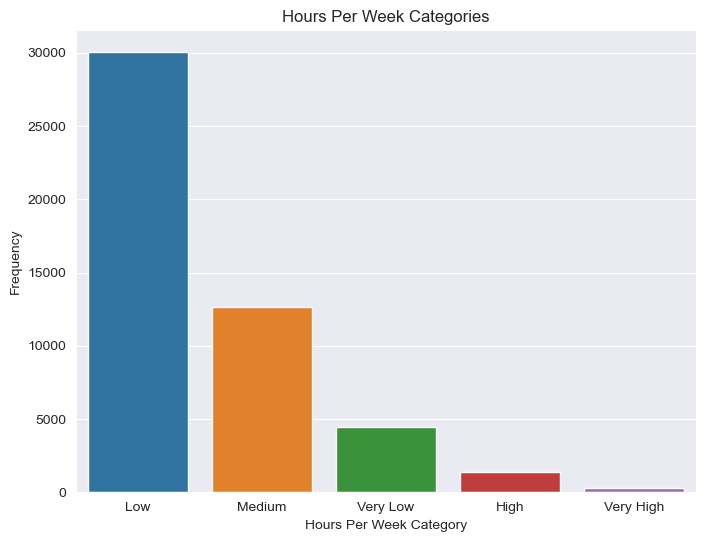

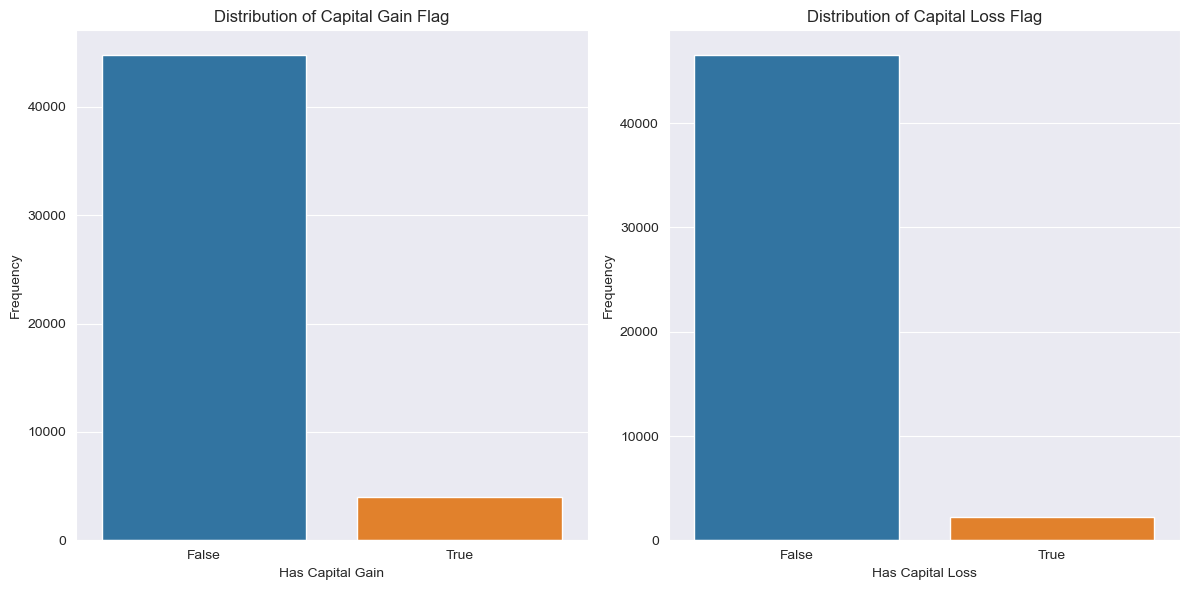

In [17]:
# Visualization for Age Group Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='age_group', data=census_data, order = census_data['age_group'].value_counts().index)
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.show()

# Visualization for Hours Per Week Categories
plt.figure(figsize=(8, 6))
sns.countplot(x='hours_per_week_cat', data=census_data, order = census_data['hours_per_week_cat'].value_counts().index)
plt.title('Hours Per Week Categories')
plt.xlabel('Hours Per Week Category')
plt.ylabel('Frequency')
plt.show()

# Visualization for Capital Gain and Loss Flags
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(ax=axes[0], x='has_capital_gain', data=census_data)
axes[0].set_title('Distribution of Capital Gain Flag')
axes[0].set_xlabel('Has Capital Gain')
axes[0].set_ylabel('Frequency')

sns.countplot(ax=axes[1], x='has_capital_loss', data=census_data)
axes[1].set_title('Distribution of Capital Loss Flag')
axes[1].set_xlabel('Has Capital Loss')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 48842 non-null  int64   
 1   workclass           46043 non-null  object  
 2   fnlwgt              48842 non-null  int64   
 3   education           48842 non-null  object  
 4   education-num       48842 non-null  int64   
 5   marital-status      48842 non-null  object  
 6   occupation          46033 non-null  object  
 7   relationship        48842 non-null  object  
 8   race                48842 non-null  object  
 9   sex                 48842 non-null  object  
 10  capital-gain        48842 non-null  int64   
 11  capital-loss        48842 non-null  int64   
 12  hours-per-week      48842 non-null  int64   
 13  native-country      47985 non-null  object  
 14  income              48842 non-null  object  
 15  age_group           48842 non-null  

# Dealing with Categorical Variables

In [19]:
# Transforming the Target Variable
census_data['income_above_50K'] = census_data['income'].map({'<=50K': 0, '>50K': 1})

# Encoding categorical variables
# Identify categorical columns (excluding the newly created target variable)
categorical_columns = census_data.select_dtypes(include=['object', 'category']).columns.drop('income')

# One-hot encoding
census_data_encoded = pd.get_dummies(census_data, columns=categorical_columns, drop_first=True)





# Data Splitting 

In [20]:
# Splitting the data into training and testing sets
X = census_data_encoded.drop(['income', 'income_above_50K'], axis=1)  # Drop the original and target variable
y = census_data_encoded['income_above_50K']  # New target variable

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Building: Random Forest & KNeighbors Classifier

In [21]:
# Training Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Training KNeighbors Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)


KNeighborsClassifier()

# Model Building: SVM & Decision Tree Classifier

In [22]:
# Training Support Vector Machine
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

# Training Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=5)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

# Model Evaluation: Random Forest & KNeighbors Classifier

In [23]:
# Evaluating Random Forest Classifier
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Evaluating KNeighborsClassifier
y_pred_knn = knn_model.predict(X_test_scaled)
print("KNeighborsClassifier Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


Random Forest Classifier Accuracy: 0.8588002456834778
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     11233
           1       0.73      0.63      0.68      3420

    accuracy                           0.86     14653
   macro avg       0.81      0.78      0.79     14653
weighted avg       0.85      0.86      0.86     14653

KNeighborsClassifier Accuracy: 0.8256329761823518
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89     11233
           1       0.64      0.58      0.61      3420

    accuracy                           0.83     14653
   macro avg       0.76      0.74      0.75     14653
weighted avg       0.82      0.83      0.82     14653



# Model Evaluation: SVM & Decision Tree Classifier

In [24]:
# Evaluating Support Vector Machine
y_pred_svm = svm_model.predict(X_test_scaled)
print("Support Vector Machine Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

# Evaluating Decision Tree Classifier
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Classifier Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Support Vector Machine Accuracy: 0.851361495939398
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     11233
           1       0.76      0.54      0.63      3420

    accuracy                           0.85     14653
   macro avg       0.81      0.74      0.77     14653
weighted avg       0.84      0.85      0.84     14653

Decision Tree Classifier Accuracy: 0.8580495461680202
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     11233
           1       0.79      0.54      0.64      3420

    accuracy                           0.86     14653
   macro avg       0.83      0.75      0.78     14653
weighted avg       0.85      0.86      0.85     14653



# Feature Importance

In [26]:
# Feature Importance for Random Forest
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, 
                                      index=X_train.columns, 
                                      columns=['importance']).sort_values('importance', ascending=False)
print("Feature Importances for Random Forest:\n", feature_importances_rf.head(10))


Feature Importances for Random Forest:
                                    importance
fnlwgt                               0.151338
age                                  0.132633
marital-status_Married-civ-spouse    0.072310
hours-per-week                       0.064757
capital-gain                         0.055586
total_capital                        0.050545
education-num                        0.044999
marital-status_Never-married         0.031667
capital-loss                         0.018196
relationship_Not-in-family           0.017798


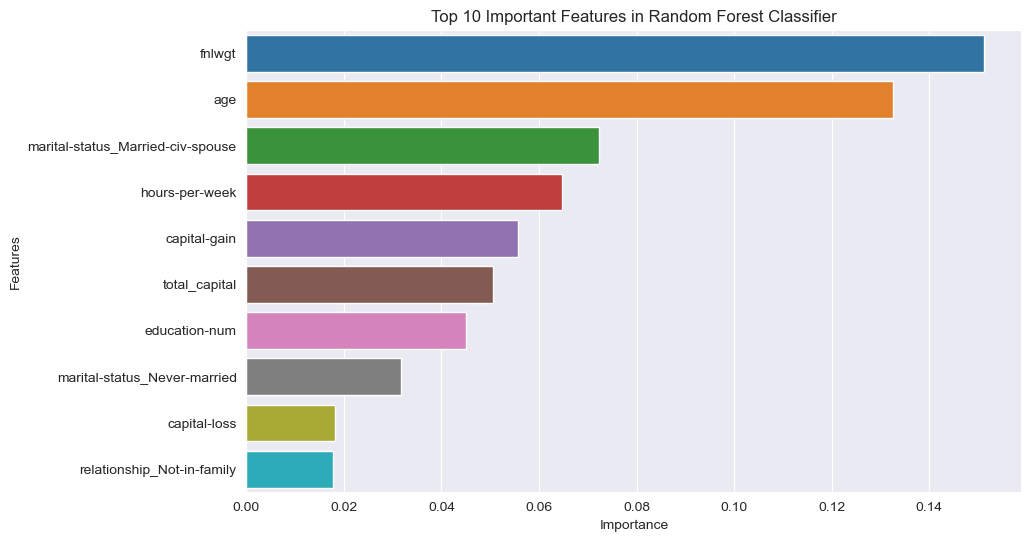

In [27]:
# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf.head(10)['importance'], y=feature_importances_rf.head(10).index)
plt.title('Top 10 Important Features in Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [28]:
# Feature Importance for Decision Tree
feature_importances_dt = pd.DataFrame(dt_model.feature_importances_, 
                                      index=X_train.columns, 
                                      columns=['importance']).sort_values('importance', ascending=False)
print("Feature Importances for Decision Tree:\n", feature_importances_dt.head(10))

Feature Importances for Decision Tree:
                                    importance
marital-status_Married-civ-spouse    0.469017
education-num                        0.233383
total_capital                        0.146151
capital-gain                         0.115226
hours-per-week                       0.021312
age                                  0.012097
capital-loss                         0.002150
edu_occ_Masters_Farming-fishing      0.000379
edu_occ_HS-grad_Other-service        0.000286
edu_occ_Assoc-voc_Farming-fishing    0.000000


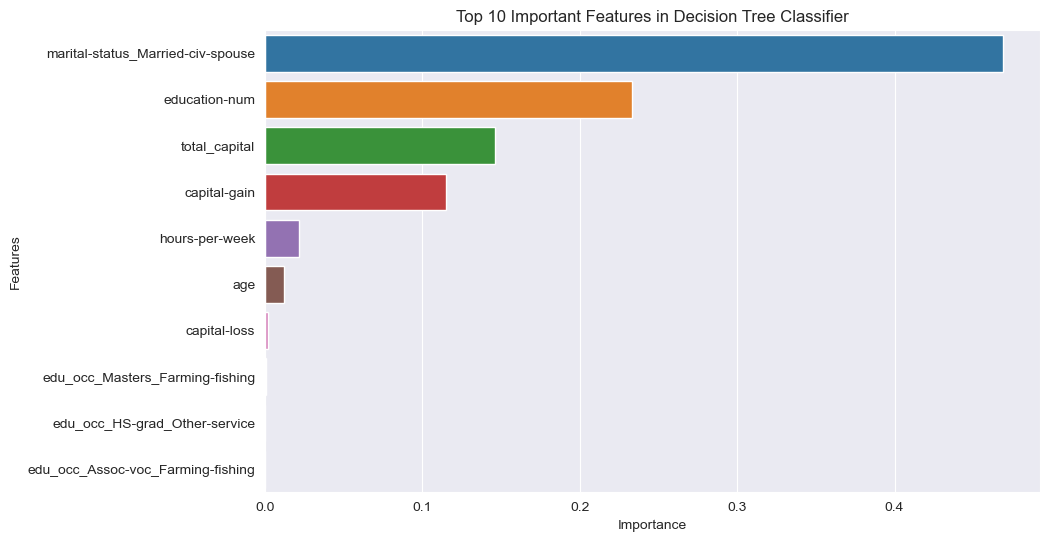

In [29]:
# Plotting feature importances for Decision Tree
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_dt.head(10)['importance'], y=feature_importances_dt.head(10).index)
plt.title('Top 10 Important Features in Decision Tree Classifier')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Confusion Matrix: Random Forest Classifier & KNeighbors Classifier 

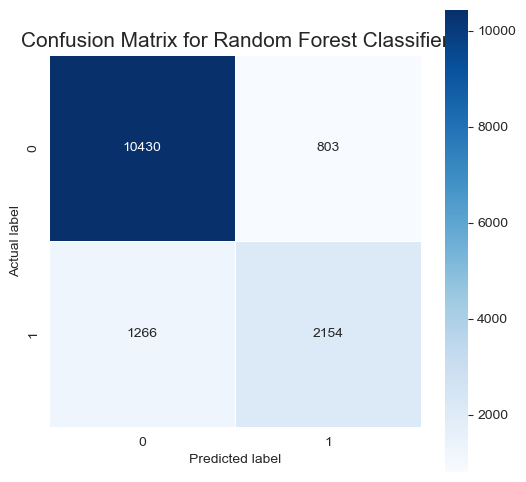

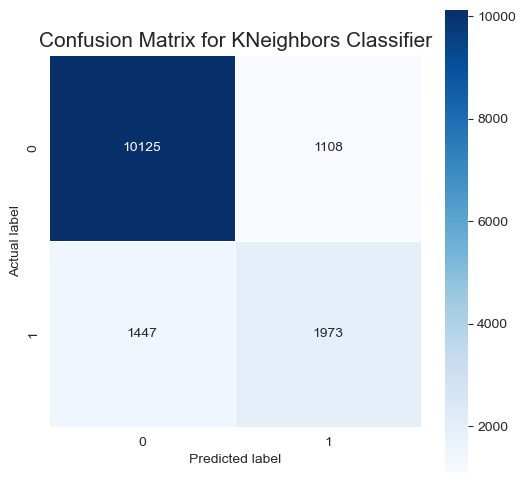

In [32]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title, size = 15)
    plt.show()

# Confusion Matrix for Random Forest Classifier
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, "Confusion Matrix for Random Forest Classifier")

# Confusion Matrix for KNeighborsClassifier
cm_knn = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(cm_knn, "Confusion Matrix for KNeighbors Classifier")


# Confusion Matrix: SVM & Decision Tree Classifier

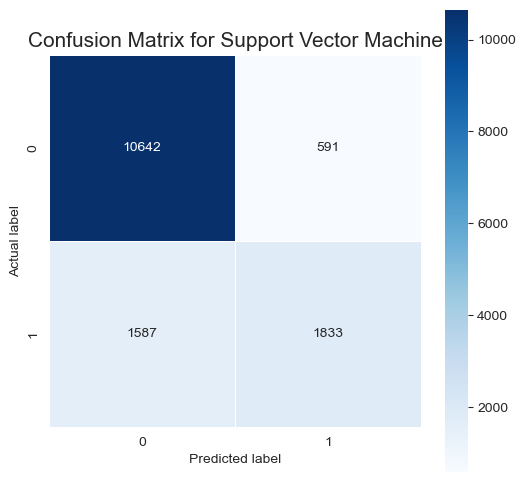

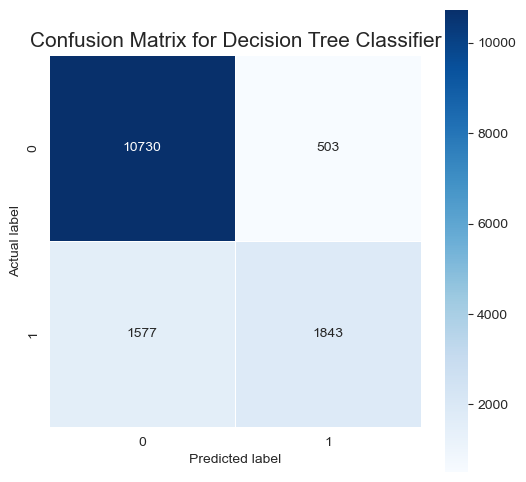

In [33]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title, size = 15)
    plt.show()

# Confusion Matrix for Support Vector Machine
cm_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm_svm, "Confusion Matrix for Support Vector Machine")

# Confusion Matrix for Decision Tree Classifier
cm_dt = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm_dt, "Confusion Matrix for Decision Tree Classifier")

# Overall Remarks


The project has successfully used economic census data to predict income brackets, providing a multi-layered understanding of socio-economic factors through data science techniques.

In the EDA phase, we uncovered a diverse age distribution and predominant sectors, with a notable number of individuals in private sector jobs and with high school or college education. This phase set the foundation for subsequent analyses.

The feature engineering phase added value by creating insightful features like age groups and flags for capital gain and loss, which painted a more nuanced picture of financial investment patterns and their impacts on income levels.

The performance of the Random Forest Classifier was commendable, with an accuracy of approximately 85.88%. The model's precision for the >50K income category was at 73%, indicating its effectiveness in predicting higher-income individuals. However, the recall of 63% suggested the model's limitation in identifying all higher-income individuals, a potential area for improvement.

The F1-score stood at 68% for the >50K income category, offering a balanced measure of precision and recall. Feature importance analysis indicated that 'fnlwgt', 'age', marital status, 'hours per week', 'total capital', and 'education-num' were significant in influencing income levels, highlighting the complex interactions of socio-economic factors.

Further evaluations through confusion matrices revealed that while all models performed well, certain models like the Decision Tree Classifier showed a tendency to be more conservative in predicting the higher income category, leading to a higher number of false negatives. The confusion matrices for the Support Vector Machine and KNeighbors Classifier indicated a relatively better balance in predicting both income categories, though still with room for improvement in terms of recall.

The insights from this analysis are not only valuable for businesses in market segmentation and targeted strategies but also for policymakers to address economic disparities. The models underscore the effectiveness of machine learning in socio-economic analysis and suggest a roadmap for continuous improvement through data enrichment, algorithm experimentation, and model validation.

The project concludes with a recognition of data science's potential in socio-economic contexts, highlighting the importance of evolving research and application in this domain, backed by robust data-driven methodologies.

In terms of model implications and future recommendations, the project suggests several areas for enhancement:

1. **Data Enrichment:** Incorporating additional variables like regional economic indicators could provide a more comprehensive view and potentially improve model accuracy.

2. **Algorithm Experimentation:** Exploring other machine learning algorithms, such as gradient boosting or neural networks, might yield better prediction results, especially in terms of recall for the higher income bracket.

3. **Continuous Model Validation:** Given the dynamic nature of economic data, the model should be regularly updated and validated with new data to maintain its relevance and accuracy.

To conclude, this project not only provides a clear demonstration of the capabilities of data science in socio-economic contexts but also opens up pathways for further research and application in this domain.